In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [3]:
# Script definitions
# ------------------

# DAXPY - data_1.csv
# Histogram_1 - data_2.csv
# Histogram_2 - data_3.csv

data_file = '../../lab2/data/data_1.csv'
images_dir = '../images/daxpy'

# Fix values for the number of operations
# Value indicated in the lab2 documentation
# 6 * 1024 * 1024 * 1024 = 6 GB in 8 bytes (double) elements

fixed_n = (6 * 1024 * 1024 * 1024) / 8

In [4]:
# Create the output directory if it doesn't exist
if not os.path.exists(images_dir):

	os.mkdir(images_dir)

else :

	os.system("rm -r " + images_dir)
	os.mkdir(images_dir)

In [5]:
# Load the data into a pandas DataFrame
data = pd.read_csv(data_file, sep=',', header=None)

# Add column names to the DataFrame
# DAXPY - printf("PAE,%d,%d,%d,%f,%f,%f,%f,%f,%f,%ld,%f,PAE\n", threadsPerBlock, blocksPerGrid, maxBlocksPerSM, occupancy, overhead, alloc_time, init_time, daxpy_time, total_time, n, alpha);
# Histogram - printf("\nPAE,%s,%d,%d,%d,%f,%f,%f,%f,%f,%f,%f,%f,%ld,PAE\n", imagePath, threadsPerBlock, blocksPerGrid, maxBlocksPerSM, occupancy, overhead, alloc_time, init_time, histogram_time, hd_time, dh_time, total_time, imageSize);

data.columns = ['threadsPerBlock', 'blocksPerGrid', 'maxBlocksPerSM', 'occupancy', 'overhead', 'alloc_time', 'init_time', 'daxpy_time', 'dh_time', 'total_time', 'n', 'alpha']

# Print total number of rows and columns in the DataFrame
print("Total rows: {0}".format(len(data)))

Total rows: 880


In [6]:
data = data[data['overhead'] < 0.1]

print("Total rows: {0}".format(len(data)))

Total rows: 880


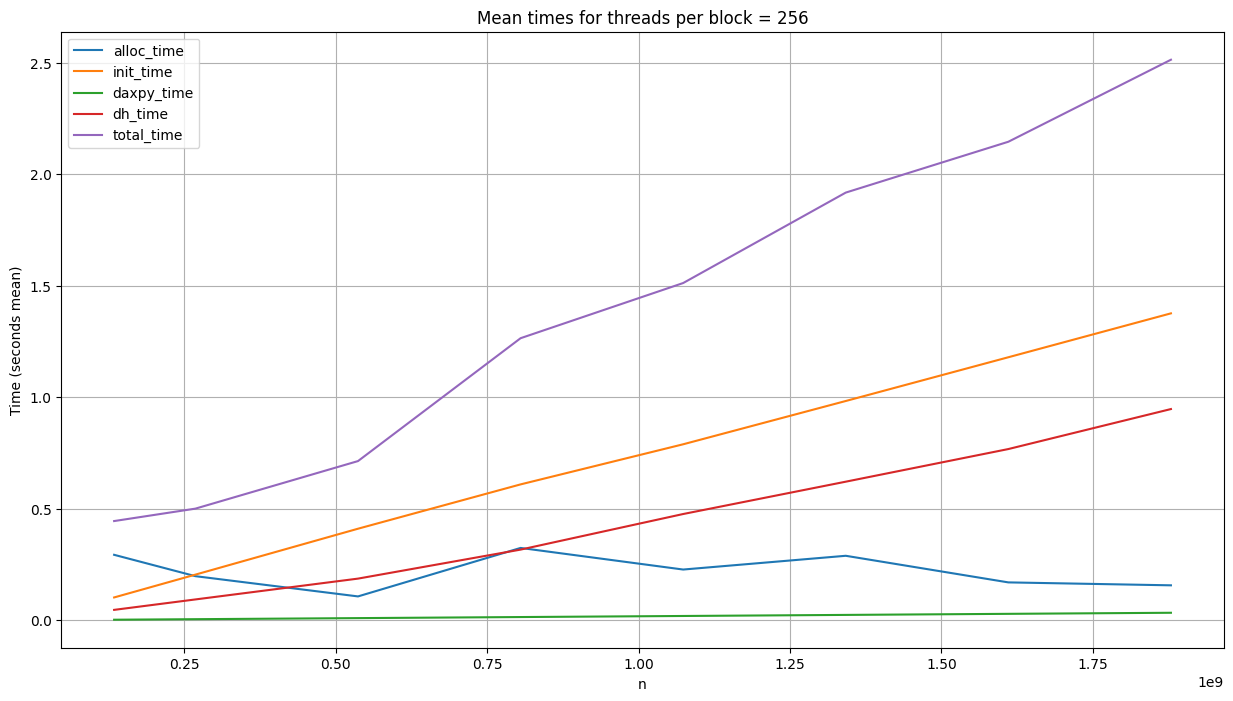

In [7]:
data_256 = data[data['threadsPerBlock'] == 256]

mean_alloc_time = data_256.groupby('n')['alloc_time'].mean()
mean_init_time = data_256.groupby('n')['init_time'].mean()
mean_daxpy_time = data_256.groupby('n')['daxpy_time'].mean()
mean_dh_time = data_256.groupby('n')['dh_time'].mean()
mean_total_time = data_256.groupby('n')['total_time'].mean()

plt.figure(figsize=(15, 8))

plt.plot(mean_alloc_time.index, mean_alloc_time, label='alloc_time')
plt.plot(mean_init_time.index, mean_init_time, label='init_time')
plt.plot(mean_daxpy_time.index, mean_daxpy_time, label='daxpy_time')
plt.plot(mean_dh_time.index, mean_dh_time, label='dh_time')
plt.plot(mean_total_time.index, mean_total_time, label='total_time')

plt.xlabel('n')
plt.ylabel('Time (seconds mean)')

plt.title('Mean times for threads per block = 256')

plt.legend()
plt.grid()

plt.savefig(os.path.join(images_dir, 'mean_times_256.png'))

plt.show()

In [15]:
data_filtered = data[data['n'] == fixed_n]

df_filtered = data_filtered[['threadsPerBlock', 'occupancy', 'daxpy_time']]

df_max_occupancy = df_filtered[df_filtered['occupancy'] > 0.9]

grouped = df_max_occupancy.groupby('threadsPerBlock')['daxpy_time'].mean()

display(grouped)

min_daxpy_time = grouped.idxmin()

print("Threads per block to get min daxpy time with full occupancy: {0}".format(min_daxpy_time))

threadsPerBlock
64      0.014270
128     0.014427
256     0.014401
512     0.014402
1024    0.014419
Name: daxpy_time, dtype: float64

Threads per block to get min daxpy time with full occupancy: 64


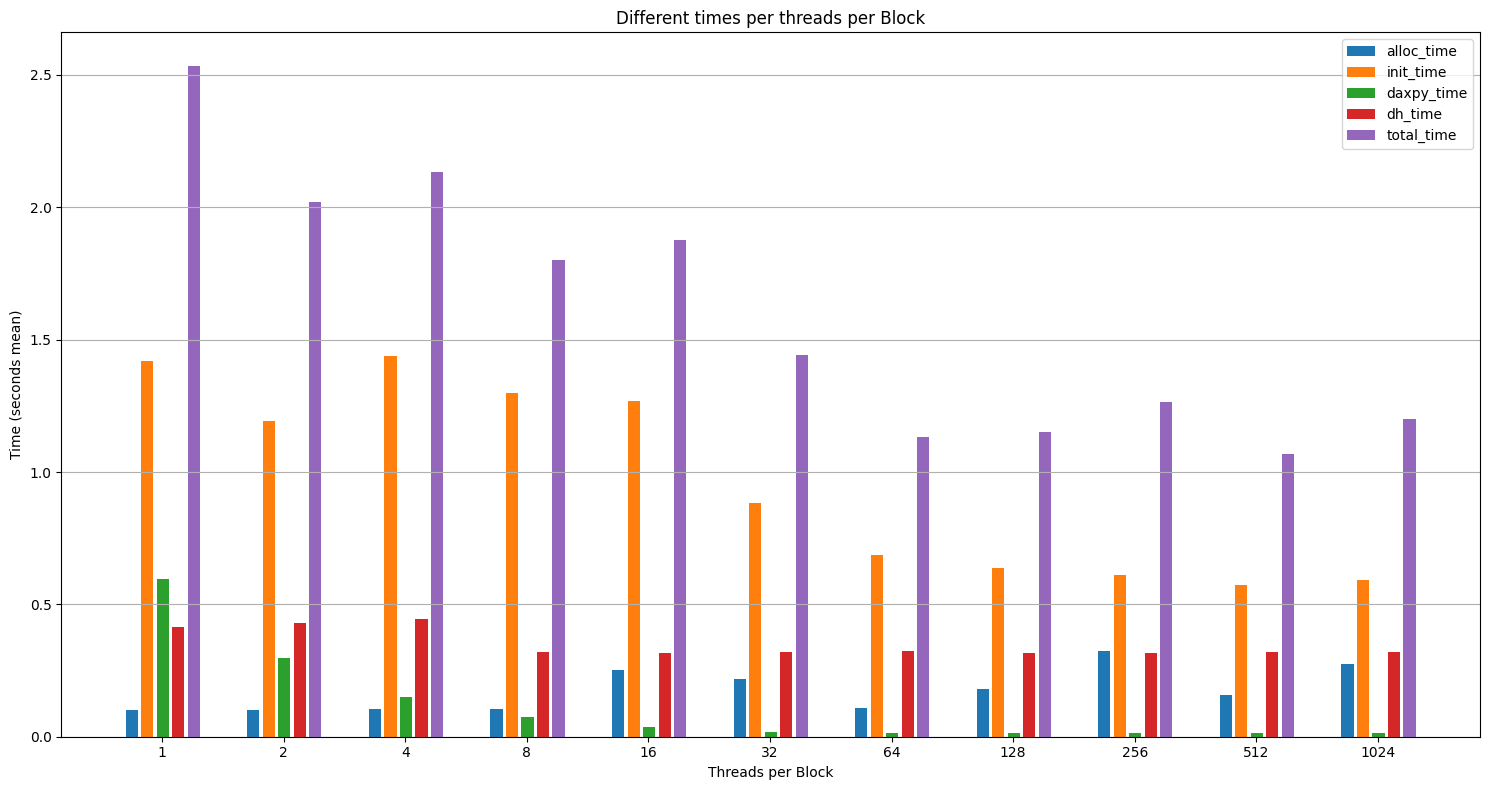

In [9]:
# Bar plot with all diferent times per threadsPerBlock unique values
# -----------------------------------------------------------------

data_filtered = data[data['n'] == fixed_n]

unique_threadsPerBlock = data_filtered['threadsPerBlock'].unique()
n_groups = len(unique_threadsPerBlock)
metrics = ['alloc_time', 'init_time', 'daxpy_time', 'dh_time', 'total_time']
n_metrics = len(metrics)
bar_width = 0.1
index = np.arange(n_groups)

plt.figure(figsize=(15, 8))

for j, metric in enumerate(metrics):

	means = [data_filtered[data_filtered['threadsPerBlock'] == tp][metric].mean() for tp in unique_threadsPerBlock]
	plt.bar(index + j * bar_width * 1.275, means, bar_width, label=metric)

plt.xlabel('Threads per Block')
plt.ylabel('Time (seconds mean)')

plt.xticks(index + bar_width * (n_metrics / 2), unique_threadsPerBlock)

plt.title('Different times per threads per Block')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

plt.savefig(os.path.join(images_dir, 'times_per_threadsPerBlock.png'))

plt.show()

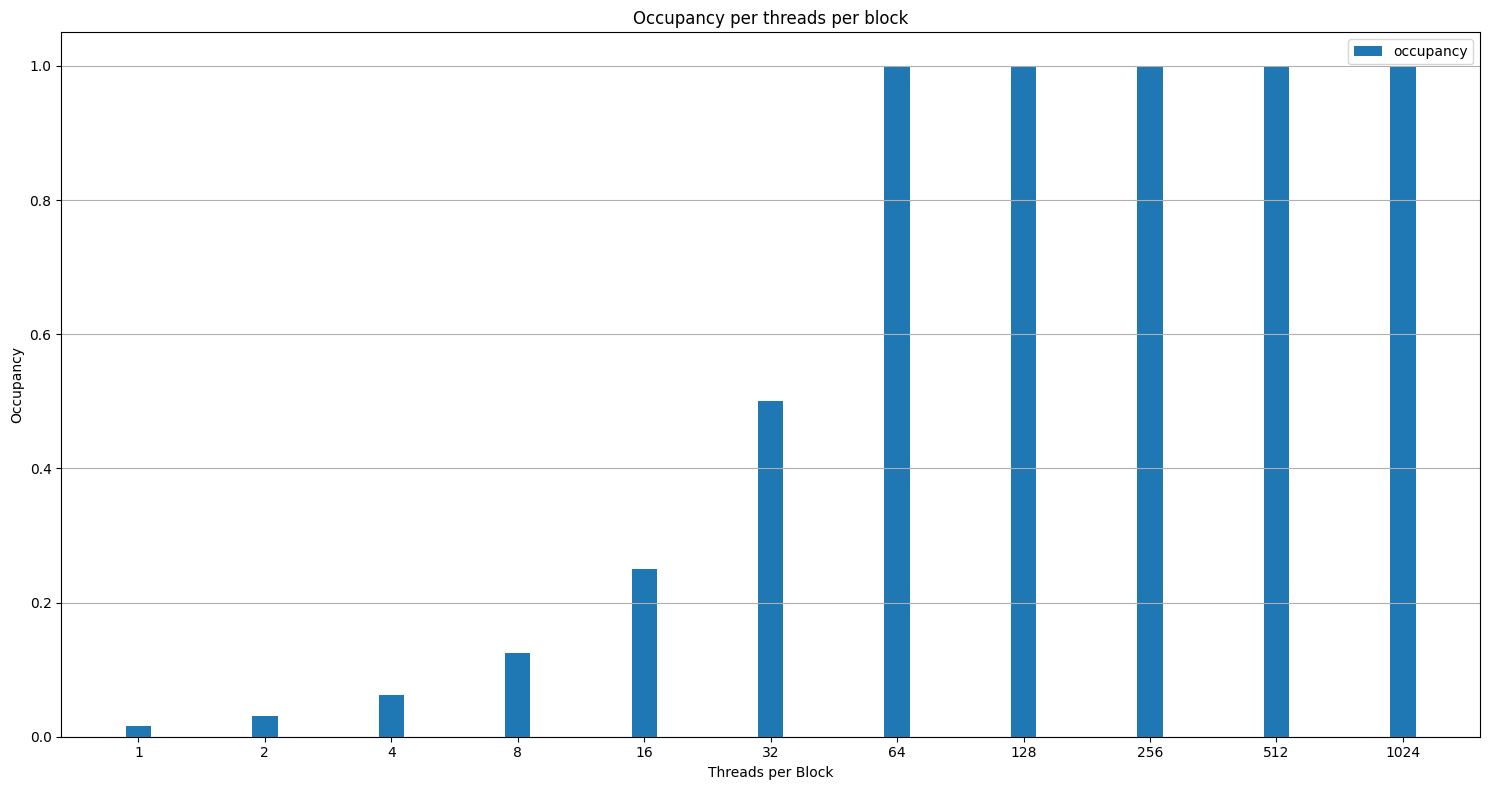

In [10]:

data_filtered = data[data['n'] == fixed_n]

unique_threadsPerBlock = data_filtered['threadsPerBlock'].unique()
n_groups = len(unique_threadsPerBlock)
metrics = ['occupancy']
n_metrics = len(metrics)

bar_width = 0.2
index = np.arange(n_groups)

plt.figure(figsize=(15, 8))

for j, metric in enumerate(metrics):

	means = [data_filtered[data_filtered['threadsPerBlock'] == tp][metric].mean() for tp in unique_threadsPerBlock]
	plt.bar(index + j * bar_width, means, bar_width, label=metric)

plt.xlabel('Threads per Block')
plt.ylabel('Occupancy')
plt.xticks(index, unique_threadsPerBlock)

plt.title('Occupancy per threads per block')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

plt.savefig(os.path.join(images_dir, 'occupancy_per_threadsPerBlock.png'))

plt.show()

In [ ]:
finalData = []

data_filtered = data[data['n'] != 0]

min_process = data_filtered['threadsPerBlock'].min()

ref_dataset = data_filtered[data_filtered['threadsPerBlock'] == min_process]

ref_times = ref_dataset.groupby('n')['daxpy_time'].max()

for (n_value, threads_value), group in data_filtered.groupby(['n', 'threadsPerBlock']):

	max_compute_time = group['daxpy_time'].max()
	max_total_time = group['total_time'].max()

	ref_time = ref_times.get(n_value, None)

	speedup = ref_time / max_compute_time
	efficiency = speedup / threads_value

	# Secuential daxpy time 0.8514 seconds and total time 4.3128s
	# Histogram - 0.2045 seconds and 0.6341 seconds

	secuential_compute_speedup = 0.8514 / max_compute_time
	secuential_total_speedup = 4.3128 / max_total_time

	quality = 1 / max_compute_time

	finalData.append([threads_value, n_value, max_compute_time, ref_time, speedup, efficiency, quality, secuential_compute_speedup, secuential_total_speedup])

final_df = pd.DataFrame(finalData, columns=['threads', 'n', 'MaxTime', 'RefTime', 'Speedup', 'Efficiency', 'Quality', 'SecuentialComputeSpeedup', 'SecuentialTotalSpeedup'])

display(final_df)

# Generate table latex code for the final_df DataFrame fixed to 2 decimal places
# final_df.to_latex(os.path.join(images_dir, 'final_df.tex'), index=False, float_format="%.2f")

,threads,n,MaxTime,RefTime,Speedup,Efficiency,Quality,SecuentialComputeSpeedup,SecuentialTotalSpeedup
0,1,134217728,0.103215,0.103215,1.000000,1.000000,9.688515,8.248801,3.759374
1,2,134217728,0.049735,0.103215,2.075287,1.037643,20.106446,17.118628,10.425575
2,4,134217728,0.024880,0.103215,4.148503,1.037126,40.192835,34.220180,10.483238
3,8,134217728,0.012454,0.103215,8.287397,1.035925,80.292570,68.361094,6.758005
4,16,134217728,0.006228,0.103215,16.573029,1.035814,160.568037,136.707626,11.463193
...,...,...,...,...,...,...,...,...,...
83,64,1879048192,0.033357,1.391918,41.727462,0.651992,29.978397,25.523607,1.499721
84,128,1879048192,0.033582,1.391918,41.448000,0.323813,29.777622,25.352668,1.441636
85,256,1879048192,0.033611,1.391918,41.412723,0.161768,29.752278,25.331090,1.589125
86,512,1879048192,0.033680,1.391918,41.327644,0.080718,29.691154,25.279049,1.614862


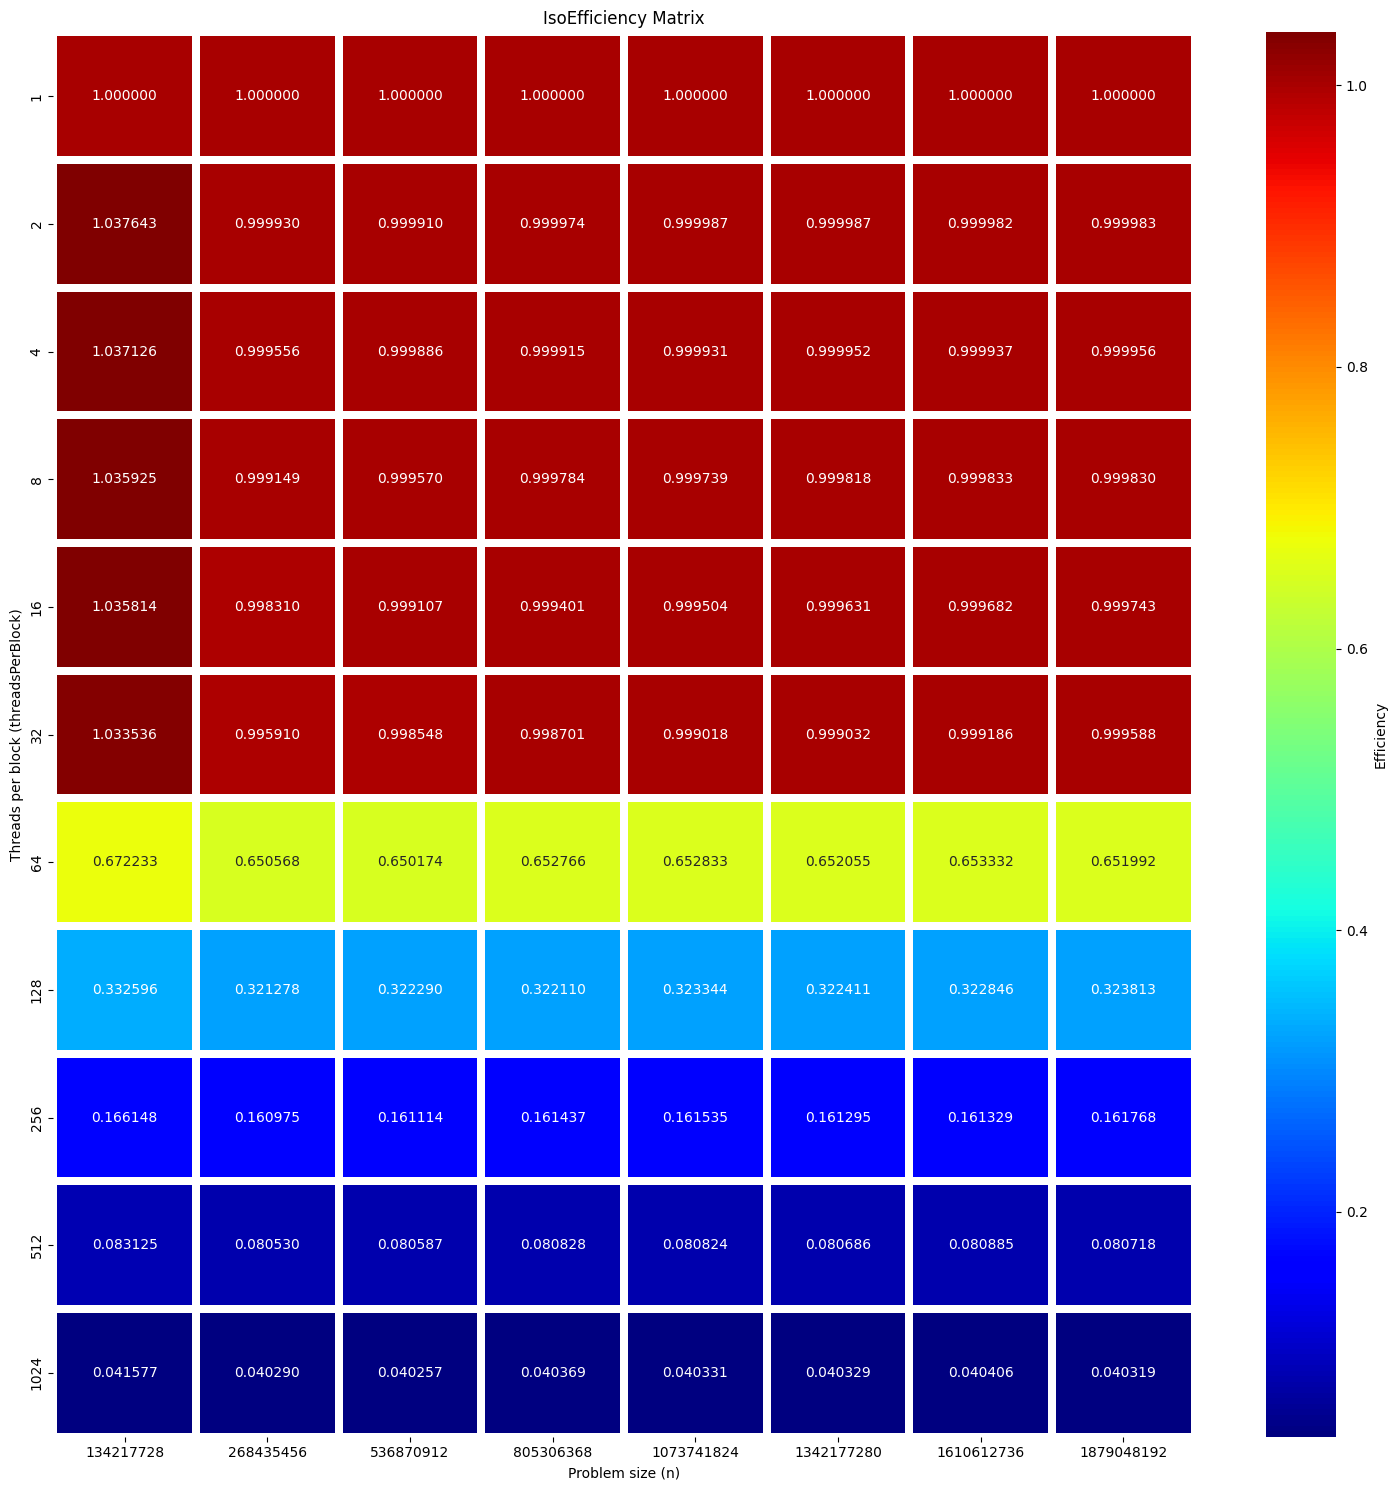

In [12]:
efficiency_matrix = final_df.pivot(index='threads', columns='n', values='Efficiency')

plt.figure(figsize=(15, 15))

ax = sns.heatmap(efficiency_matrix, annot=True, fmt=".6f", cmap='jet', cbar_kws={'label': 'Efficiency'}, linewidths=4.5, linecolor='white')

ax.set_title("IsoEfficiency Matrix")
ax.set_xlabel("Problem size (n)")
ax.set_ylabel("Threads per block (threadsPerBlock)")

plt.tight_layout()

plt.savefig(os.path.join(images_dir, 'isoEfficiencyMatrix.png'))

plt.show()